# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, plot_roc_curve, classification_report
from math import exp
from IPython.display import HTML
import random
import shap


In [2]:
csv_url = 'https://github.com/automoto/big-five-data/blob/master/big_five_scores.csv'
df=pd.read_csv('big_five_scores.csv', index_col=0)

In [3]:
def hide_toggle(text='Toggle', for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = text + ' show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307313 entries, 1 to 334161
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   country                  307141 non-null  object 
 1   age                      307313 non-null  int64  
 2   sex                      307313 non-null  int64  
 3   agreeable_score          307313 non-null  float64
 4   extraversion_score       307313 non-null  float64
 5   openness_score           307313 non-null  float64
 6   conscientiousness_score  307313 non-null  float64
 7   neuroticism_score        307313 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 21.1+ MB


In [5]:
NAN_rows = df.shape[0] - df.dropna().shape[0]
NAN_percent = NAN_rows/df.shape[0]
print(f"The amount of rows containig nan values is {(NAN_percent * 100):.2f}% ")

The amount of rows containig nan values is 0.06% 


Drop all nan values after review that there are less than 0.1%

In [6]:
data = df.dropna()

In [7]:
data.describe()

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score
count,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000
mean,25.193953,1.602557,0.696809,0.672328,0.733943,0.702013,0.574405
std,10.002145,0.489370,0.093565,0.108672,0.087612,0.107376,0.125743
min,10.000000,1.000000,0.200000,0.200000,0.253333,0.206667,0.196667
25%,18.000000,1.000000,0.640000,0.600000,0.673333,0.630000,0.486667
50%,22.000000,2.000000,0.703333,0.680000,0.736667,0.706667,0.570000
75%,29.000000,2.000000,0.763333,0.750000,0.796667,0.776667,0.660000
max,99.000000,2.000000,1.000000,0.993333,0.996667,1.000000,0.996667


In [8]:
gender_count = data['sex'].value_counts(normalize=True)
print(f"The data containes {(gender_count.iloc[0]*100):.2f}% female's surveys and {(gender_count.iloc[1]*100):.2f}% male's surveys")

The data containes 60.26% female's surveys and 39.74% male's surveys


In [9]:
# g = sns.pairplot(data, hue='sex')
# new_labels = ['Male', 'Female']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# _=g

In [10]:
# personality_traits = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score','neuroticism_score']
# data1 = pd.melt(data, id_vars=['sex'], value_vars=personality_traits)
# data1.loc[(data1.sex == 1),'sex'] = 'Male'
# data1.loc[(data1.sex == 2),'sex'] = 'Female'
# fig, ax = plt.subplots(figsize = (15, 10))
# m = sns.boxplot(ax=ax, data=data1, x="variable", y="value", hue="sex")

In [11]:
# data_age_melt = pd.melt(data, id_vars=['sex'], value_vars=['age'])
# data_age_melt.loc[(data_age_melt.sex == 1),'sex'] = 'Male'
# data_age_melt.loc[(data_age_melt.sex == 2),'sex'] = 'Female'
# fig, ax = plt.subplots(figsize = (15, 10))
# m = sns.boxplot(ax=ax, data=data_age_melt, x="variable", y="value", hue="sex")

How many countries are in the data


In [12]:
len(data.country.unique())

235

How many observations there are for each country in the data

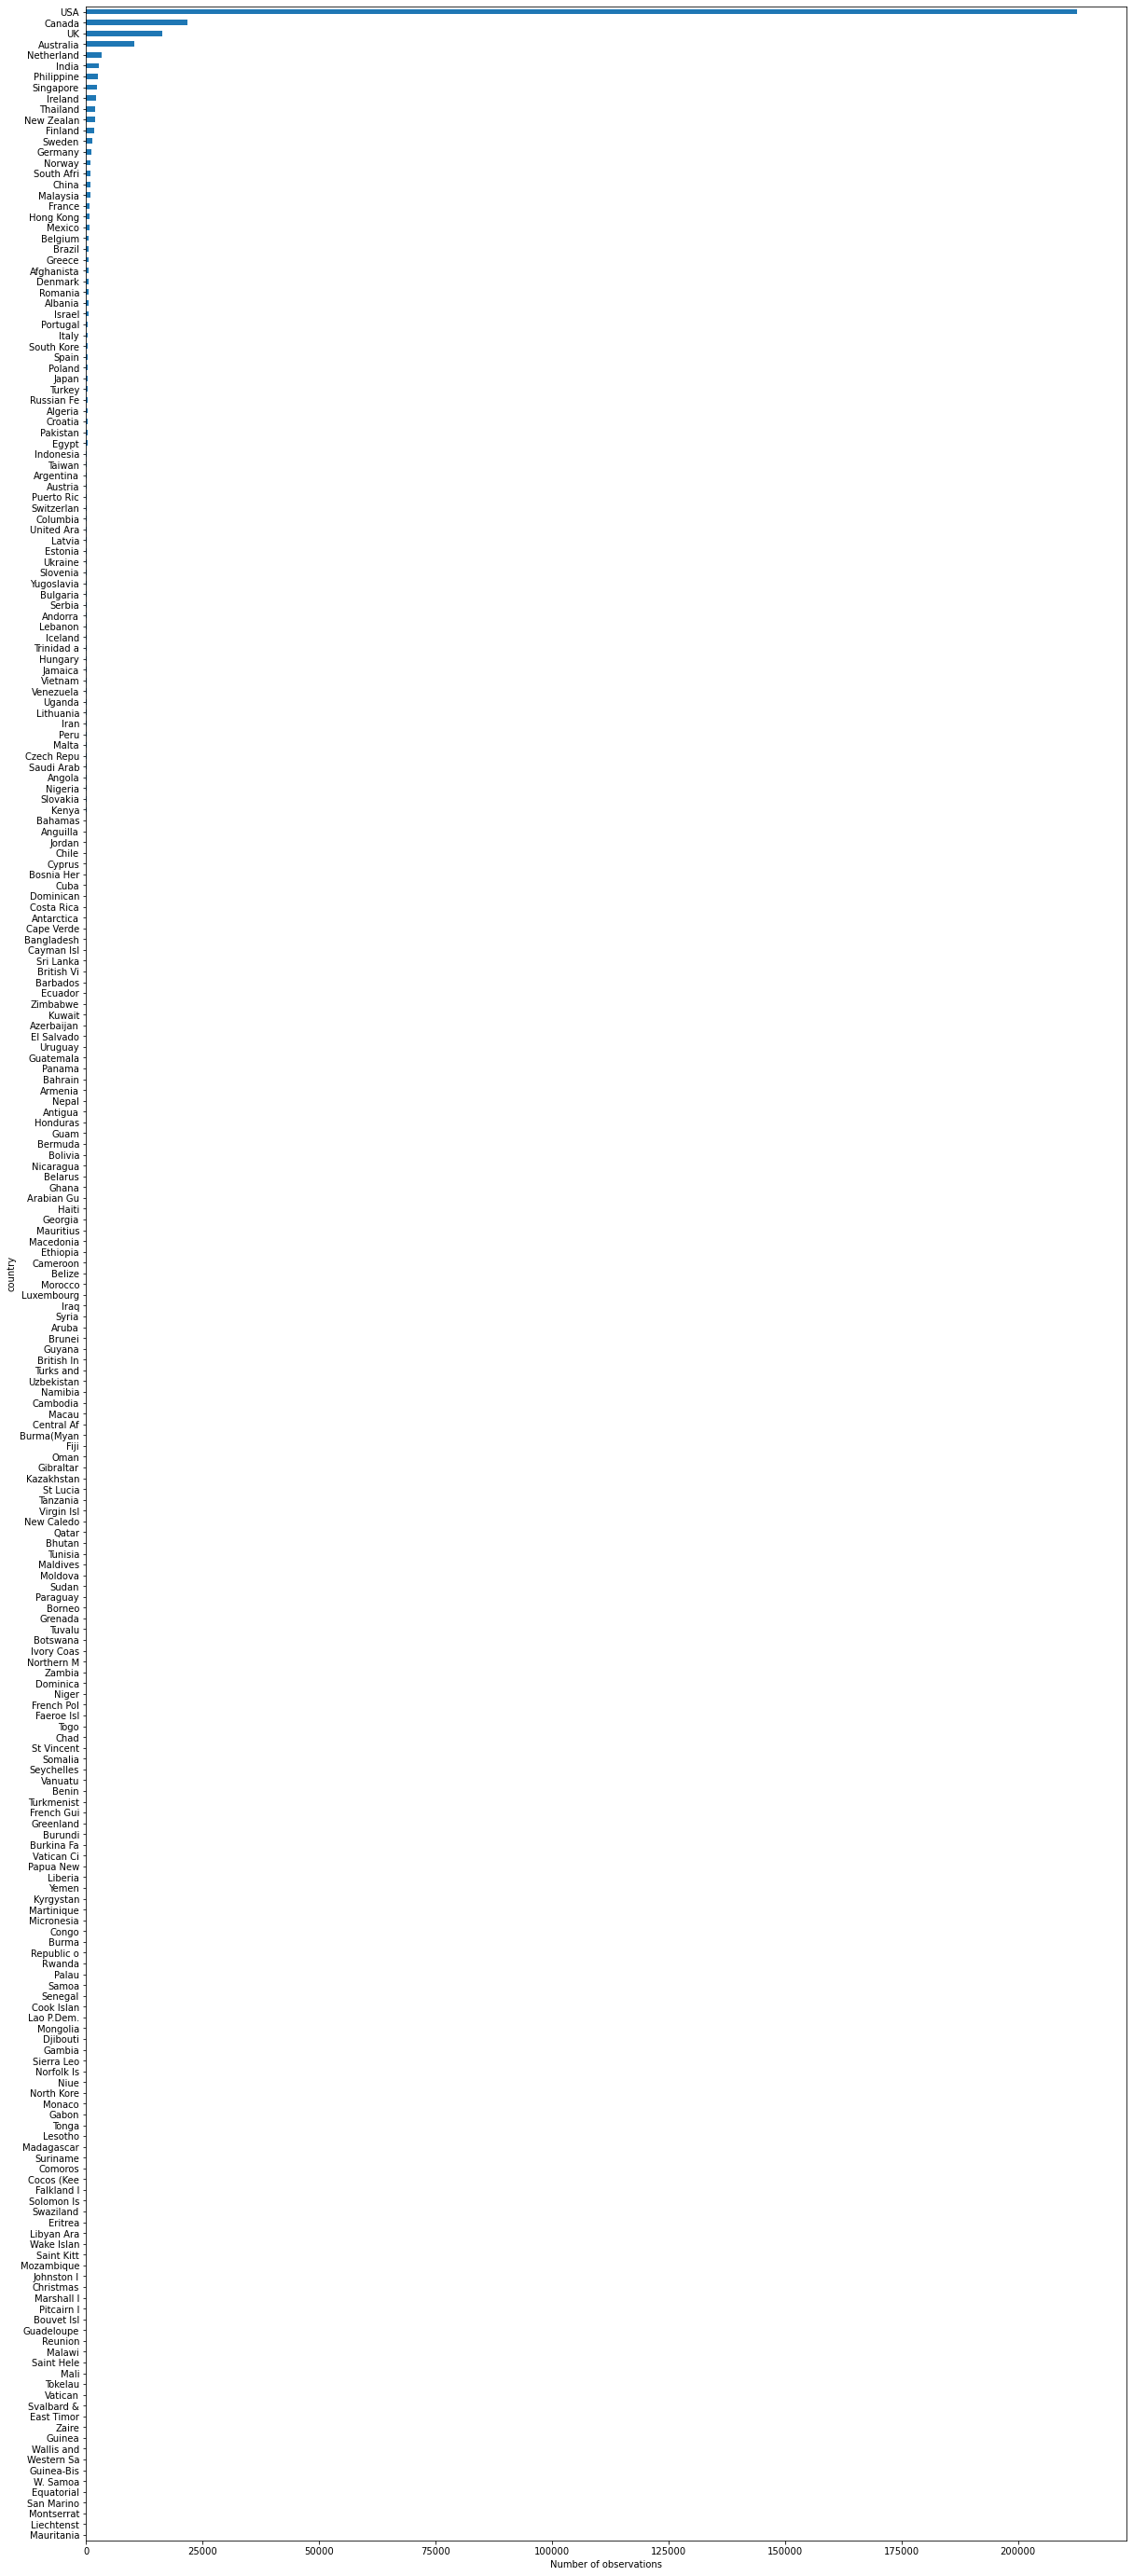

In [13]:
country = data.groupby(['country'])['age'].count().sort_values(ascending=True)
_=country.plot(kind='barh', figsize=(20,50))
_=plt.xlabel("Number of observations")

gender: more women than men - not balanced
age: not as in world's population 
countries: only 12 countries with more than 0.5% observations, and USA has a big advantage (69%)

# Preprocessing

according to the exploratory data analysis we decided to:
1. balance the data (gender)
2. use only observations from countries with significant amount of survey (more than 0.5%)
3. Normalize the data

we decided to divide the process to three, using different data and comparing the results:
1. raw_data: the original data without NaN and only with significant countries one-hot encoding
2. balanced_data: raw_data downsampled to match populations' gender distribution
3. balanced_interacted_data: balanced_data with feature interaction

### raw data

Narrow countries to only ones with more than significant percent of the data.


In [14]:
data_lenght = len(data)
significant_percent = 0.005
significant_observations = significant_percent * data_lenght
country[country > significant_observations]

country
Finland         1853
New Zealan      2016
Thailand        2059
Ireland         2102
Singapore       2450
Philippine      2488
India           2841
Netherland      3469
Australia      10400
UK             16489
Canada         21798
USA           212625
Name: age, dtype: int64

In [15]:
country_list = country[country > significant_observations].index.values.tolist()

Build Dataframes of chosen country binary variables and join with data 

In [16]:
countries = pd.get_dummies(data['country'][data['country'].isin(country_list)])
data_country = pd.concat([data, countries] ,axis=1)
data_country.insert(20, 'Other', np.where(np.isnan(data_country['UK'].values), 1, 0)) #add 'other' country column
raw_data = data_country.fillna(0).drop(['country'], axis=1)

In [17]:
raw_data.head()

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score,Australia,Canada,Finland,India,Ireland,Netherland,New Zealan,Philippine,Singapore,Thailand,UK,USA,Other
case_id,,,,,,,,,,,,,,,,,,,,
1,24,1,0.753333,0.496667,0.803333,0.886667,0.426667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,24,2,0.733333,0.680000,0.786667,0.746667,0.590000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,36,2,0.880000,0.770000,0.860000,0.896667,0.296667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
5,19,1,0.690000,0.616667,0.716667,0.636667,0.563333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
6,17,1,0.600000,0.713333,0.646667,0.633333,0.513333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [18]:
#Normalize features
scaler = MinMaxScaler()
names = raw_data.columns
d = scaler.fit_transform(raw_data)
scaled_raw_data = pd.DataFrame(d, index=raw_data.index, columns=names)

### spliting the data to train and test 

In [19]:
target_name = 'sex'
scaled_raw_train, scaled_raw_test = train_test_split(scaled_raw_data)

In [20]:
scaled_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230355 entries, 36637 to 41518
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      230355 non-null  float64
 1   sex                      230355 non-null  float64
 2   agreeable_score          230355 non-null  float64
 3   extraversion_score       230355 non-null  float64
 4   openness_score           230355 non-null  float64
 5   conscientiousness_score  230355 non-null  float64
 6   neuroticism_score        230355 non-null  float64
 7   Australia                230355 non-null  float64
 8   Canada                   230355 non-null  float64
 9   Finland                  230355 non-null  float64
 10  India                    230355 non-null  float64
 11  Ireland                  230355 non-null  float64
 12  Netherland               230355 non-null  float64
 13  New Zealan               230355 non-null  float64
 14  P

In [21]:
scaled_raw_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76786 entries, 80310 to 97132
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      76786 non-null  float64
 1   sex                      76786 non-null  float64
 2   agreeable_score          76786 non-null  float64
 3   extraversion_score       76786 non-null  float64
 4   openness_score           76786 non-null  float64
 5   conscientiousness_score  76786 non-null  float64
 6   neuroticism_score        76786 non-null  float64
 7   Australia                76786 non-null  float64
 8   Canada                   76786 non-null  float64
 9   Finland                  76786 non-null  float64
 10  India                    76786 non-null  float64
 11  Ireland                  76786 non-null  float64
 12  Netherland               76786 non-null  float64
 13  New Zealan               76786 non-null  float64
 14  Philippine        

### balanced_data

there are 50.5% men i the world, and 49.5% females in the world (https://countrymeters.info/en/World) The original data containes 60.26% female's surveys and 39.74% male's surveys we'll try to oversample and undersample our data

In [22]:
minority_class = scaled_raw_train['sex'].value_counts()[0]
print(f"The scaled_raw_train data containes {(scaled_raw_train['sex'].value_counts()[1])} female's surveys and {(scaled_raw_train['sex'].value_counts()[0])} male's surveys")

The scaled_raw_train data containes 138675 female's surveys and 91680 male's surveys


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


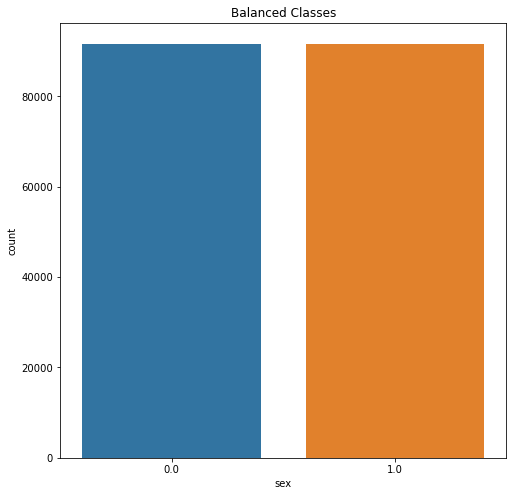

In [23]:
# Shuffle the Dataset.
shuffled_df = scaled_raw_train.sample(frac=1,random_state=4)

# Put all the male class in a separate dataset.
male_df = shuffled_df.loc[shuffled_df['sex'] == 0] #0= male, 1= female

#Randomly select minority_class number observations from the female (majority class)
female_df = shuffled_df.loc[shuffled_df['sex'] == 1].sample(n=minority_class,random_state=42)

# Concatenate both dataframes again
balanced_train = pd.concat([male_df, female_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('sex', data=balanced_train)
plt.title('Balanced Classes')
plt.show()

### balanced_interacted_data

add interactions columns of personality traits

In [24]:
Personality_Traits_list = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score', 'neuroticism_score']

In [25]:
#Run on Personality_Traits and multiply scores of any two pairs
def feature_interactions(data: pd.DataFrame, Personality_Traits_list: list):
    """
    multiply any two columns of Personality_Traits and save the result in a new column.

    Parameters
    ---------
    data: pd.DataFrame
    Personality_Traits_list: list
        Features's list of Personality_Traits
    
    return 
    """
    interacted_data = data.copy()
    i = 0
    j = i+1
    while i < (len(Personality_Traits_list)-1):
        new_feature = Personality_Traits_list[i] + '*' + Personality_Traits_list[j]
        interacted_data[new_feature] = interacted_data[Personality_Traits_list[i]] * interacted_data[Personality_Traits_list[i]]
        j = j+1
        if j == len(Personality_Traits_list):
            i= i+1
            j=i+1
    return interacted_data

In [26]:
balanced_interacted_train = feature_interactions(balanced_train, Personality_Traits_list)
interacted_test = feature_interactions(scaled_raw_test, Personality_Traits_list) #the test data was not balanced, we only add the interaction columns

In [27]:
balanced_interacted_train

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score,Australia,Canada,Finland,...,agreeable_score*extraversion_score,agreeable_score*openness_score,agreeable_score*conscientiousness_score,agreeable_score*neuroticism_score,extraversion_score*openness_score,extraversion_score*conscientiousness_score,extraversion_score*neuroticism_score,openness_score*conscientiousness_score,openness_score*neuroticism_score,conscientiousness_score*neuroticism_score
case_id,,,,,,,,,,,,,,,,,,,,,
252428,0.067416,0.0,0.700000,0.399160,0.336323,0.445378,0.466667,0.0,0.0,0.0,...,0.490000,0.490000,0.490000,0.490000,0.159328,0.159328,0.159328,0.113113,0.113113,0.198362
136655,0.325843,0.0,0.625000,0.638655,0.533632,0.768908,0.204167,0.0,0.0,0.0,...,0.390625,0.390625,0.390625,0.390625,0.407881,0.407881,0.407881,0.284763,0.284763,0.591219
126589,0.179775,0.0,0.591667,0.680672,0.636771,0.739496,0.287500,0.0,0.0,0.0,...,0.350069,0.350069,0.350069,0.350069,0.463315,0.463315,0.463315,0.405478,0.405478,0.546854
170451,0.168539,0.0,0.529167,0.659664,0.452915,0.596639,0.525000,0.0,0.0,0.0,...,0.280017,0.280017,0.280017,0.280017,0.435156,0.435156,0.435156,0.205132,0.205132,0.355978
303332,0.089888,0.0,0.504167,0.529412,0.497758,0.714286,0.329167,0.0,0.0,0.0,...,0.254184,0.254184,0.254184,0.254184,0.280277,0.280277,0.280277,0.247763,0.247763,0.510204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120278,0.213483,1.0,0.795833,0.768908,0.641256,0.731092,0.308333,0.0,0.0,0.0,...,0.633351,0.633351,0.633351,0.633351,0.591219,0.591219,0.591219,0.411209,0.411209,0.534496
144251,0.247191,1.0,0.520833,0.256303,0.789238,0.478992,0.779167,0.0,0.0,0.0,...,0.271267,0.271267,0.271267,0.271267,0.065691,0.065691,0.065691,0.622896,0.622896,0.229433
26205,0.258427,1.0,0.650000,0.533613,0.479821,0.693277,0.450000,0.0,0.0,0.0,...,0.422500,0.422500,0.422500,0.422500,0.284743,0.284743,0.284743,0.230228,0.230228,0.480633


In [28]:
interacted_test

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score,Australia,Canada,Finland,...,agreeable_score*extraversion_score,agreeable_score*openness_score,agreeable_score*conscientiousness_score,agreeable_score*neuroticism_score,extraversion_score*openness_score,extraversion_score*conscientiousness_score,extraversion_score*neuroticism_score,openness_score*conscientiousness_score,openness_score*neuroticism_score,conscientiousness_score*neuroticism_score
case_id,,,,,,,,,,,,,,,,,,,,,
80310,0.067416,1.0,0.654167,0.760504,0.614350,0.743697,0.329167,0.0,0.0,0.0,...,0.427934,0.427934,0.427934,0.427934,0.578367,0.578367,0.578367,0.377426,0.377426,0.553086
1899,0.348315,1.0,0.587500,0.512605,0.515695,0.617647,0.529167,0.0,0.0,0.0,...,0.345156,0.345156,0.345156,0.345156,0.262764,0.262764,0.262764,0.265941,0.265941,0.381488
171823,0.123596,0.0,0.358333,0.571429,0.618834,0.659664,0.616667,0.0,0.0,0.0,...,0.128403,0.128403,0.128403,0.128403,0.326531,0.326531,0.326531,0.382956,0.382956,0.435156
43042,0.303371,0.0,0.587500,0.428571,0.775785,0.462185,0.629167,0.0,0.0,0.0,...,0.345156,0.345156,0.345156,0.345156,0.183673,0.183673,0.183673,0.601842,0.601842,0.213615
15580,0.112360,1.0,0.654167,0.747899,0.609865,0.563025,0.633333,0.0,0.0,0.0,...,0.427934,0.427934,0.427934,0.427934,0.559353,0.559353,0.559353,0.371936,0.371936,0.316997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314468,0.202247,1.0,0.683333,0.827731,0.713004,0.852941,0.354167,0.0,0.0,0.0,...,0.466944,0.466944,0.466944,0.466944,0.685139,0.685139,0.685139,0.508375,0.508375,0.727509
293789,0.179775,0.0,0.754167,0.462185,0.802691,0.449580,0.700000,0.0,0.0,0.0,...,0.568767,0.568767,0.568767,0.568767,0.213615,0.213615,0.213615,0.644312,0.644312,0.202122
127445,0.067416,1.0,0.391667,0.386555,0.784753,0.546218,0.208333,0.0,0.0,0.0,...,0.153403,0.153403,0.153403,0.153403,0.149424,0.149424,0.149424,0.615838,0.615838,0.298355


in the preprocessing we also tried:
K-Mean, outliers handeling and PCA
but eventually decided not to use them, because it didn't help the prediction

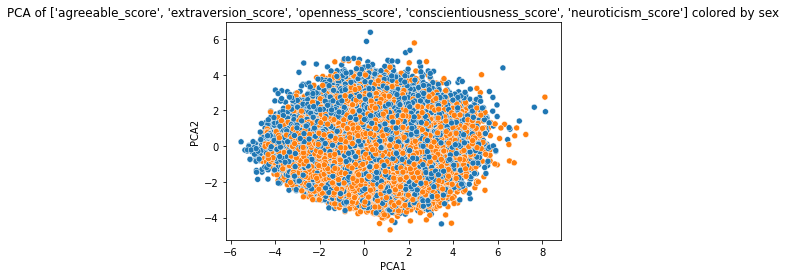

In [29]:
#PCA
def pca_plot(data: pd.DataFrame, features: list, color_col: str ="sex"):
    """
    Plots the PCA as desired. 

    Parameters
    ---------
    data: pd.DataFrame
    features: list
        Features's list that we would like to reduce dimension
    ax_i: plt.axes
    color_col: str
        name of column to color the dots by.
    """
    x_only = data_country[features]

    pca_model = make_pipeline(StandardScaler(), PCA(n_components=2))
    pca_model.fit(x_only)

    X_2D = pca_model.transform(x_only)
    pca_dict = dict(PCA1=X_2D[:, 0], PCA2=X_2D[:, 1])
    pca_results = pd.DataFrame(pca_dict)

    color_series = data.loc[:, (color_col)].reset_index(drop=True)

    pca_results["color"] = color_series

    g = sns.scatterplot(data=pca_results, x="PCA1", y="PCA2", hue="color")
    g.legend_.remove()
    g.set(title=f"PCA of {features} colored by {color_col}")
_=pca_plot(scaled_raw_data, Personality_Traits_list)
hide_toggle('PCA')

In [30]:
#Kmeans
Kmeans = KMeans(n_clusters=3)
Kmeans.fit(scaled_raw_data[Personality_Traits_list])
y_km = Kmeans.fit_predict(scaled_raw_data[Personality_Traits_list])
new_series = pd.Series(y_km, index=scaled_raw_data.index, name='cluster')
scaled_raw_data_Kmeans = pd.concat([scaled_raw_data, new_series] ,axis=1)
#Evaluation of the cluster result 
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).median()
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).count()
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).mean()
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).sum()
hide_toggle('Kmeans')

In [31]:
train_datasets = [scaled_raw_train, balanced_train, balanced_interacted_train]

# Models

we tried few models (Logistic regression, Linear regression, Decision trees, Gradient Boosting).
the best results were given by Logistic regression and  Gradient Boosting, we will show them here:

### Logistic regression

In [51]:
target_name = 'sex'

models_list = []
X_test_list = []
y_test_list = []
y_predicted_list = []
datasets_names = ['scaled_raw', 'balanced', 'balanced_interacted']

run on all 3 datas with Logistic regression:

In [52]:
for train_data in train_datasets:
    
    #split train and test to X and y:
    X_train = train_data.drop(columns=[target_name])
    y_train = train_data[target_name].copy()   
    #fit the model according to train data
    Lreg = LogisticRegression(max_iter=100000).fit(X_train, y_train)
    #save model to model list
    models_list.append(Lreg)
    
    #different kind of test data because of the added columns
    if (train_data.equals(balanced_interacted_train)):

        X_test = interacted_test.drop(columns=[target_name])
        y_test = interacted_test[target_name].copy()   
    else:
        #first two options
        X_test = scaled_raw_test.drop(columns=[target_name])
        y_test = scaled_raw_test[target_name].copy()   
        
    X_test_list.append(X_test)
    y_test_list.append(y_test)

    
    #predict 
    y_predicted = Lreg.predict(X_test)
    y_predicted_list.append(y_predicted)
    

In [53]:
models_list

[LogisticRegression(max_iter=100000),
 LogisticRegression(max_iter=100000),
 LogisticRegression(max_iter=100000)]

In [54]:
y_predicted_list

[array([1., 1., 1., ..., 0., 1., 0.]),
 array([1., 0., 0., ..., 0., 1., 0.]),
 array([1., 0., 0., ..., 0., 1., 0.])]

Plot results for 3 datas:

Plots for  scaled_raw
              precision    recall  f1-score   support

        Male       0.65      0.48      0.55     30391
      Female       0.71      0.83      0.77     46395

    accuracy                           0.69     76786
   macro avg       0.68      0.66      0.66     76786
weighted avg       0.69      0.69      0.68     76786



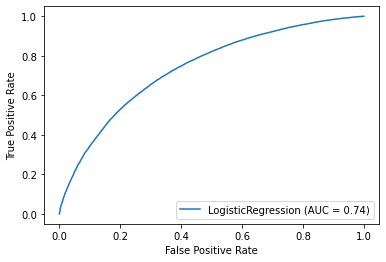

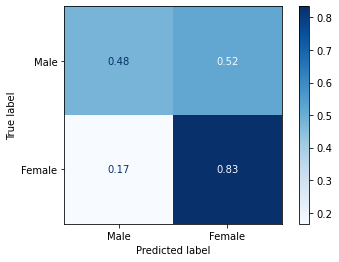

Plots for  balanced
              precision    recall  f1-score   support

        Male       0.58      0.67      0.62     30391
      Female       0.76      0.69      0.72     46395

    accuracy                           0.68     76786
   macro avg       0.67      0.68      0.67     76786
weighted avg       0.69      0.68      0.68     76786



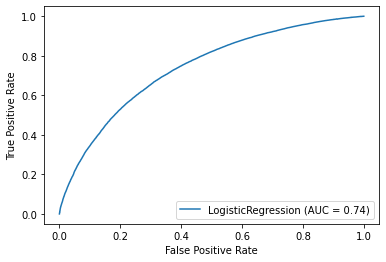

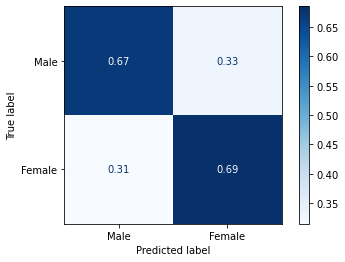

Plots for  balanced_interacted
              precision    recall  f1-score   support

        Male       0.58      0.68      0.62     30391
      Female       0.76      0.68      0.72     46395

    accuracy                           0.68     76786
   macro avg       0.67      0.68      0.67     76786
weighted avg       0.69      0.68      0.68     76786



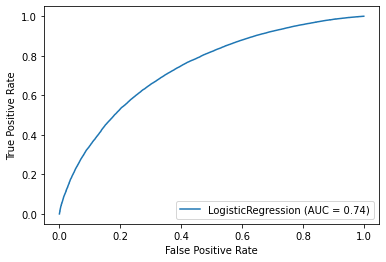

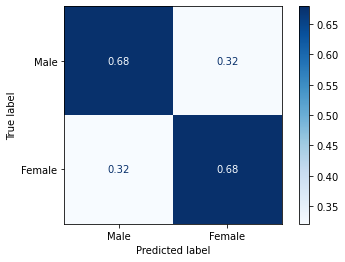

In [44]:
target_names = ['Male', 'Female']
for i in range(len(train_datasets)):
    print("Plots for ", datasets_names[i])
    _ = plot_roc_curve(models_list[i], X_test_list[i], y_test_list[i])
    report = classification_report(y_test_list[i], y_predicted_list[i], target_names=target_names)
    print(report)
    disp = plot_confusion_matrix(models_list[i],
                                 X_test_list[i],
                                 y_test_list[i],
                                 display_labels=['Male', 'Female'],
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    plt.show()

    

### Gradient Boosting

run on all 3 datas with Gradiant Boosting:

In [45]:
models_list_GB = []
y_predicted_list_GB = []
X_train_list = []

In [46]:
for train_data in train_datasets:
    
    #split train and test to X and y:
    X_train = train_data.drop(columns=[target_name])
    y_train = train_data[target_name].copy()   
    X_train_list.append(X_train)
    #fit the model according to train data
    gradient_boosting  = GradientBoostingClassifier(random_state =0).fit(X_train, y_train)
    #save model to model list
    models_list_GB.append(gradient_boosting)
    
    #different kind of test data because of the added columns
    if (train_data.equals(balanced_interacted_train)):

        X_test = interacted_test.drop(columns=[target_name])
        y_test = interacted_test[target_name].copy()   
    else:
        #first two options
        X_test = scaled_raw_test.drop(columns=[target_name])
        y_test = scaled_raw_test[target_name].copy()   
        
    #predict 
    y_predicted = gradient_boosting.predict(X_test)
    y_predicted_list_GB.append(y_predicted)

Plot results for 3 datas:

Plots for  scaled_raw
              precision    recall  f1-score   support

        Male       0.65      0.48      0.55     30391
      Female       0.71      0.83      0.77     46395

    accuracy                           0.69     76786
   macro avg       0.68      0.66      0.66     76786
weighted avg       0.69      0.69      0.68     76786



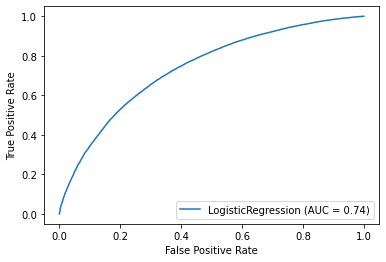

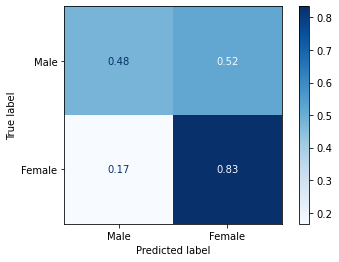

Plots for  balanced
              precision    recall  f1-score   support

        Male       0.58      0.67      0.62     30391
      Female       0.76      0.69      0.72     46395

    accuracy                           0.68     76786
   macro avg       0.67      0.68      0.67     76786
weighted avg       0.69      0.68      0.68     76786



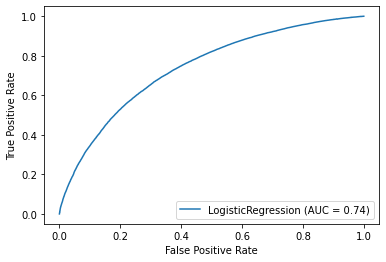

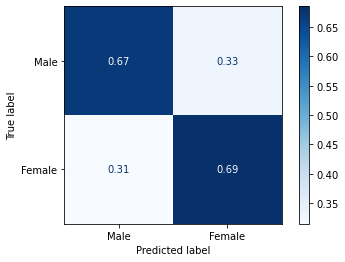

Plots for  balanced_interacted
              precision    recall  f1-score   support

        Male       0.58      0.68      0.62     30391
      Female       0.76      0.68      0.72     46395

    accuracy                           0.68     76786
   macro avg       0.67      0.68      0.67     76786
weighted avg       0.69      0.68      0.68     76786



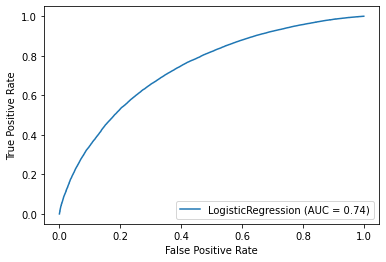

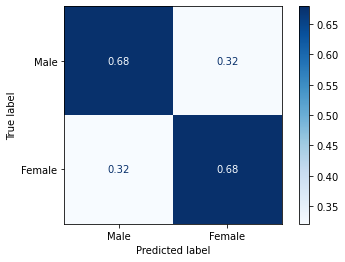

In [47]:
for i in range(len(train_datasets)):
    print("Plots for ", datasets_names[i])
    _ = plot_roc_curve(models_list[i], X_test_list[i], y_test_list[i])
    report = classification_report(y_test_list[i], y_predicted_list[i], target_names=target_names)
    print(report)
    disp = plot_confusion_matrix(models_list[i],
                                 X_test_list[i],
                                 y_test_list[i],
                                 display_labels=['Male', 'Female'],
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    plt.show()

the most significant change was balancing the data, it improved the male prediction.
if the female's recall is more important than the man's recall - the first data will be preferable.

# Explainability

### Logistic Regression model - explainability

In [55]:
def explainability_Logistic_Regression (coef: np.array, delta: float):
    value = []
    for i in range(coef.shape[1]):
        value.append(exp(Lreg.coef_[0][i]*delta))
    return value

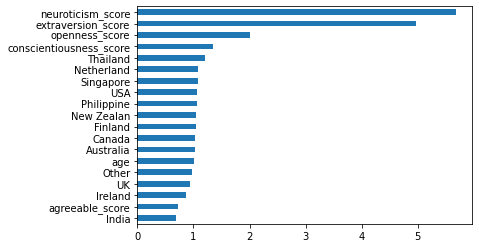

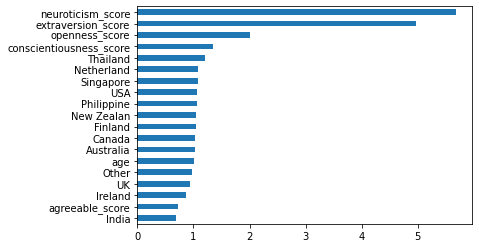

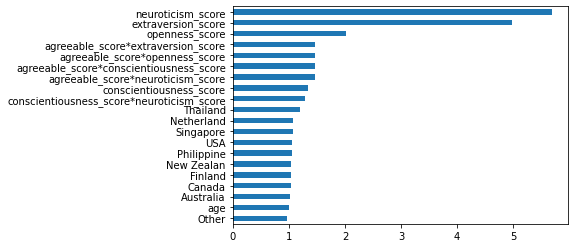

In [56]:
for i in range(len(models_list)):
    coef = models_list[i].coef_
    Explainability = explainability_Logistic_Regression(coef, 0.3) #delta is positive - probability for femal
    Explainability_df = pd.Series(np.array(Explainability),  index=X_test_list[i].columns.to_list(), name='Explainability')
    _=Explainability_df.nlargest(20).sort_values().plot(kind='barh')
    plt.show()

### Gradient Boosting model - Shap explainability

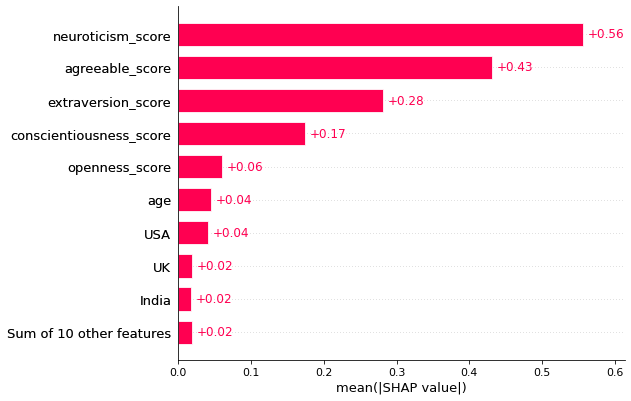

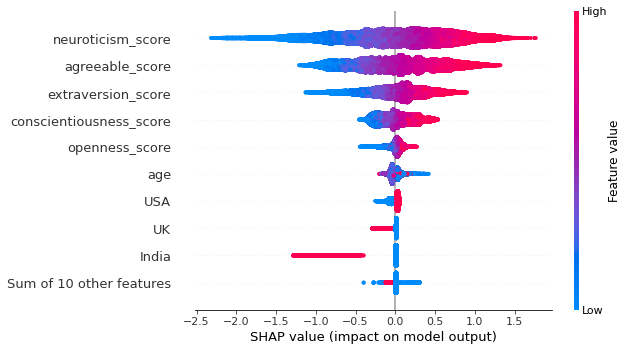

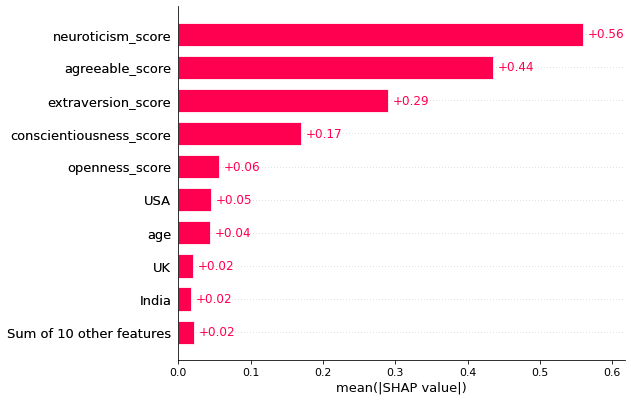

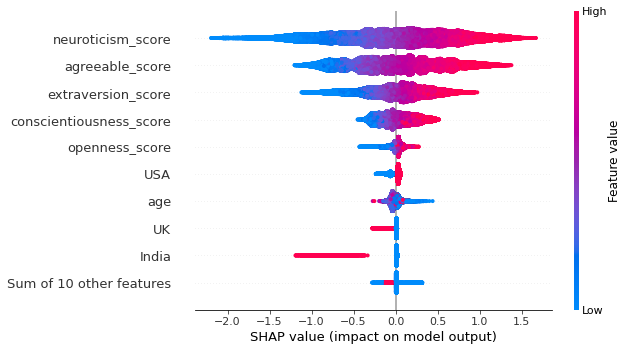

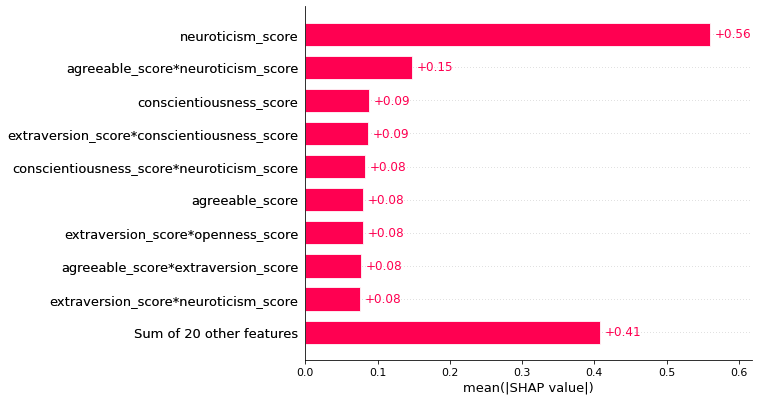

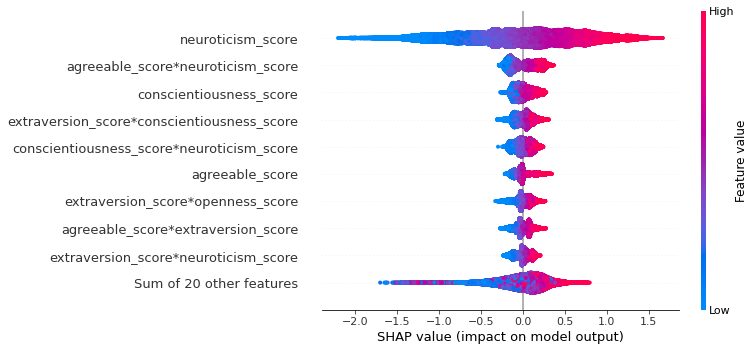

In [57]:
for i in range(len(models_list)):
    explainer = shap.Explainer(models_list_GB[i])
    shap_values = explainer(X_train_list[i])
    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)
    plt.show()
